In [790]:
from music21 import *

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

In [791]:
# get bach paths
paths = corpus.getComposer('bach')

paths = paths[:10]
notes = []
midi_notes = []
for path in paths:
    score = converter.parse(paths[0])

    # get the first part
    part = score.parts[0]

    # get all notes from the part
    notes.extend(list(map(lambda note: note, part.recurse().notes)))

midi_notes = list(map(lambda note: note.pitch.midi, notes))

print(f'len(notes): {len(notes)}')
print(f'len(midi_notes): {len(midi_notes)}')
print(midi_notes)

len(notes): 1530
len(midi_notes): 1530
[65, 67, 60, 65, 53, 57, 53, 57, 60, 65, 70, 69, 67, 65, 67, 69, 69, 65, 67, 69, 70, 72, 70, 69, 67, 67, 72, 72, 71, 69, 71, 72, 65, 65, 70, 69, 67, 65, 60, 65, 60, 60, 57, 53, 60, 60, 60, 57, 65, 67, 60, 65, 53, 57, 53, 57, 60, 65, 70, 69, 67, 65, 67, 69, 69, 65, 67, 69, 70, 72, 70, 69, 67, 67, 72, 72, 71, 69, 71, 72, 65, 65, 70, 69, 67, 65, 60, 65, 60, 60, 57, 53, 60, 60, 60, 57, 67, 60, 60, 60, 60, 60, 60, 65, 67, 65, 67, 69, 67, 65, 65, 60, 65, 60, 72, 70, 69, 70, 72, 70, 69, 67, 65, 60, 72, 60, 67, 65, 64, 65, 65, 53, 60, 60, 60, 57, 69, 67, 69, 70, 72, 72, 70, 69, 69, 67, 65, 65, 53, 60, 60, 60, 57, 65, 67, 60, 65, 53, 57, 53, 57, 60, 65, 70, 69, 67, 65, 67, 69, 69, 65, 67, 69, 70, 72, 70, 69, 67, 67, 72, 72, 71, 69, 71, 72, 65, 65, 70, 69, 67, 65, 60, 65, 60, 60, 57, 53, 60, 60, 60, 57, 65, 67, 60, 65, 53, 57, 53, 57, 60, 65, 70, 69, 67, 65, 67, 69, 69, 65, 67, 69, 70, 72, 70, 69, 67, 67, 72, 72, 71, 69, 71, 72, 65, 65, 70, 69, 67, 65, 60, 

In [792]:
# turn notes in to training sequences of 5
# map each sequence to note that follows
# [65, 67, 60, 65, 53] -> 57
# [67, 60, 65, 53, 57] -> 53

seq_length = 6

print(f'len(midi_notes): {len(midi_notes)}')

data = []
labels = []
for i in range(len(midi_notes)):
    seq_end = i + seq_length
    
    if seq_end >= len(midi_notes): break
    
#     print(f'i: {i}')
#     print(f'seq_end: {seq_end}')
    
    seq = midi_notes[i:seq_end]        
    data.append(seq)
    labels.append(midi_notes[seq_end])

print(f'data:\n{data[:3]}')
print(f'labels:\n{labels[:3]}')

len(midi_notes): 1530
data:
[[65, 67, 60, 65, 53, 57], [67, 60, 65, 53, 57, 53], [60, 65, 53, 57, 53, 57]]
labels:
[53, 57, 60]


In [793]:
# # normalize
# from sklearn.preprocessing import MinMaxScaler

# scaler_data = MinMaxScaler(feature_range=(0, 1))
# scaler_data = scaler.fit(data)
# data_norm = scaler_data.transform(data)

# scaler_labels = MinMaxScaler(feature_range=(0, 1))
# scaler_labels = scaler.fit(labels)
# labels_norm = scaler_labels.transform(labels)

# print(data_norm.shape)
# print(labels_norm.shape)

# for i, seq in enumerate(data_norm):
#     print(f'{seq} -> {labels_norm[i]}')

In [794]:
# get the data in shape
data = np.array(data, dtype=float)
data = data.reshape(-1, seq_length, 1)
data = data / 128

labels = np.array(labels, dtype=float)
labels = labels.reshape(-1, 1)
labels = labels / 128

print(data.shape)
print(labels.shape)

for i, seq in enumerate(data):
    print(f'{seq} -> {labels[i]}')

(1524, 6, 1)
(1524, 1)
[[0.5078125]
 [0.5234375]
 [0.46875  ]
 [0.5078125]
 [0.4140625]
 [0.4453125]] -> [0.4140625]
[[0.5234375]
 [0.46875  ]
 [0.5078125]
 [0.4140625]
 [0.4453125]
 [0.4140625]] -> [0.4453125]
[[0.46875  ]
 [0.5078125]
 [0.4140625]
 [0.4453125]
 [0.4140625]
 [0.4453125]] -> [0.46875]
[[0.5078125]
 [0.4140625]
 [0.4453125]
 [0.4140625]
 [0.4453125]
 [0.46875  ]] -> [0.5078125]
[[0.4140625]
 [0.4453125]
 [0.4140625]
 [0.4453125]
 [0.46875  ]
 [0.5078125]] -> [0.546875]
[[0.4453125]
 [0.4140625]
 [0.4453125]
 [0.46875  ]
 [0.5078125]
 [0.546875 ]] -> [0.5390625]
[[0.4140625]
 [0.4453125]
 [0.46875  ]
 [0.5078125]
 [0.546875 ]
 [0.5390625]] -> [0.5234375]
[[0.4453125]
 [0.46875  ]
 [0.5078125]
 [0.546875 ]
 [0.5390625]
 [0.5234375]] -> [0.5078125]
[[0.46875  ]
 [0.5078125]
 [0.546875 ]
 [0.5390625]
 [0.5234375]
 [0.5078125]] -> [0.5234375]
[[0.5078125]
 [0.546875 ]
 [0.5390625]
 [0.5234375]
 [0.5078125]
 [0.5234375]] -> [0.5390625]
[[0.546875 ]
 [0.5390625]
 [0.5234375]
 

 [0.5234375]] -> [0.5234375]
[[0.546875 ]
 [0.5625   ]
 [0.546875 ]
 [0.5390625]
 [0.5234375]
 [0.5234375]] -> [0.5625]
[[0.5625   ]
 [0.546875 ]
 [0.5390625]
 [0.5234375]
 [0.5234375]
 [0.5625   ]] -> [0.5625]
[[0.546875 ]
 [0.5390625]
 [0.5234375]
 [0.5234375]
 [0.5625   ]
 [0.5625   ]] -> [0.5546875]
[[0.5390625]
 [0.5234375]
 [0.5234375]
 [0.5625   ]
 [0.5625   ]
 [0.5546875]] -> [0.5390625]
[[0.5234375]
 [0.5234375]
 [0.5625   ]
 [0.5625   ]
 [0.5546875]
 [0.5390625]] -> [0.5546875]
[[0.5234375]
 [0.5625   ]
 [0.5625   ]
 [0.5546875]
 [0.5390625]
 [0.5546875]] -> [0.5625]
[[0.5625   ]
 [0.5625   ]
 [0.5546875]
 [0.5390625]
 [0.5546875]
 [0.5625   ]] -> [0.5078125]
[[0.5625   ]
 [0.5546875]
 [0.5390625]
 [0.5546875]
 [0.5625   ]
 [0.5078125]] -> [0.5078125]
[[0.5546875]
 [0.5390625]
 [0.5546875]
 [0.5625   ]
 [0.5078125]
 [0.5078125]] -> [0.546875]
[[0.5390625]
 [0.5546875]
 [0.5625   ]
 [0.5078125]
 [0.5078125]
 [0.546875 ]] -> [0.5390625]
[[0.5546875]
 [0.5625   ]
 [0.5078125]
 [

[[0.5390625]
 [0.5390625]
 [0.5078125]
 [0.5234375]
 [0.5390625]
 [0.546875 ]] -> [0.5625]
[[0.5390625]
 [0.5078125]
 [0.5234375]
 [0.5390625]
 [0.546875 ]
 [0.5625   ]] -> [0.546875]
[[0.5078125]
 [0.5234375]
 [0.5390625]
 [0.546875 ]
 [0.5625   ]
 [0.546875 ]] -> [0.5390625]
[[0.5234375]
 [0.5390625]
 [0.546875 ]
 [0.5625   ]
 [0.546875 ]
 [0.5390625]] -> [0.5234375]
[[0.5390625]
 [0.546875 ]
 [0.5625   ]
 [0.546875 ]
 [0.5390625]
 [0.5234375]] -> [0.5234375]
[[0.546875 ]
 [0.5625   ]
 [0.546875 ]
 [0.5390625]
 [0.5234375]
 [0.5234375]] -> [0.5625]
[[0.5625   ]
 [0.546875 ]
 [0.5390625]
 [0.5234375]
 [0.5234375]
 [0.5625   ]] -> [0.5625]
[[0.546875 ]
 [0.5390625]
 [0.5234375]
 [0.5234375]
 [0.5625   ]
 [0.5625   ]] -> [0.5546875]
[[0.5390625]
 [0.5234375]
 [0.5234375]
 [0.5625   ]
 [0.5625   ]
 [0.5546875]] -> [0.5390625]
[[0.5234375]
 [0.5234375]
 [0.5625   ]
 [0.5625   ]
 [0.5546875]
 [0.5390625]] -> [0.5546875]
[[0.5234375]
 [0.5625   ]
 [0.5625   ]
 [0.5546875]
 [0.5390625]
 [0.5

 [0.5078125]] -> [0.5234375]
[[0.5078125]
 [0.5234375]
 [0.5390625]
 [0.5390625]
 [0.5078125]
 [0.5234375]] -> [0.5390625]
[[0.5234375]
 [0.5390625]
 [0.5390625]
 [0.5078125]
 [0.5234375]
 [0.5390625]] -> [0.546875]
[[0.5390625]
 [0.5390625]
 [0.5078125]
 [0.5234375]
 [0.5390625]
 [0.546875 ]] -> [0.5625]
[[0.5390625]
 [0.5078125]
 [0.5234375]
 [0.5390625]
 [0.546875 ]
 [0.5625   ]] -> [0.546875]
[[0.5078125]
 [0.5234375]
 [0.5390625]
 [0.546875 ]
 [0.5625   ]
 [0.546875 ]] -> [0.5390625]
[[0.5234375]
 [0.5390625]
 [0.546875 ]
 [0.5625   ]
 [0.546875 ]
 [0.5390625]] -> [0.5234375]
[[0.5390625]
 [0.546875 ]
 [0.5625   ]
 [0.546875 ]
 [0.5390625]
 [0.5234375]] -> [0.5234375]
[[0.546875 ]
 [0.5625   ]
 [0.546875 ]
 [0.5390625]
 [0.5234375]
 [0.5234375]] -> [0.5625]
[[0.5625   ]
 [0.546875 ]
 [0.5390625]
 [0.5234375]
 [0.5234375]
 [0.5625   ]] -> [0.5625]
[[0.546875 ]
 [0.5390625]
 [0.5234375]
 [0.5234375]
 [0.5625   ]
 [0.5625   ]] -> [0.5546875]
[[0.5390625]
 [0.5234375]
 [0.5234375]
 [0

 [0.546875 ]] -> [0.5390625]
[[0.46875  ]
 [0.5078125]
 [0.46875  ]
 [0.5625   ]
 [0.546875 ]
 [0.5390625]] -> [0.546875]
[[0.5078125]
 [0.46875  ]
 [0.5625   ]
 [0.546875 ]
 [0.5390625]
 [0.546875 ]] -> [0.5625]
[[0.46875  ]
 [0.5625   ]
 [0.546875 ]
 [0.5390625]
 [0.546875 ]
 [0.5625   ]] -> [0.546875]
[[0.5625   ]
 [0.546875 ]
 [0.5390625]
 [0.546875 ]
 [0.5625   ]
 [0.546875 ]] -> [0.5390625]
[[0.546875 ]
 [0.5390625]
 [0.546875 ]
 [0.5625   ]
 [0.546875 ]
 [0.5390625]] -> [0.5234375]
[[0.5390625]
 [0.546875 ]
 [0.5625   ]
 [0.546875 ]
 [0.5390625]
 [0.5234375]] -> [0.5078125]
[[0.546875 ]
 [0.5625   ]
 [0.546875 ]
 [0.5390625]
 [0.5234375]
 [0.5078125]] -> [0.46875]
[[0.5625   ]
 [0.546875 ]
 [0.5390625]
 [0.5234375]
 [0.5078125]
 [0.46875  ]] -> [0.5625]
[[0.546875 ]
 [0.5390625]
 [0.5234375]
 [0.5078125]
 [0.46875  ]
 [0.5625   ]] -> [0.46875]
[[0.5390625]
 [0.5234375]
 [0.5078125]
 [0.46875  ]
 [0.5625   ]
 [0.46875  ]] -> [0.5234375]
[[0.5234375]
 [0.5078125]
 [0.46875  ]
 [0.

In [795]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=4)

In [796]:
model = Sequential()
model.add(LSTM((128), batch_input_shape=(None, seq_length, 1), return_sequences=False))
model.add(Activation('sigmoid'))
# model.add(Dropout(0.2))
# model.add(LSTM((1), return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
# model.add(LSTM((1), return_sequences=False))
# model.add(Dense(1, activation='sigmoid'))


In [797]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
print(model.input_shape)
print(model.output_shape)
print(model.summary())

(None, 6, 1)
(None, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_93 (LSTM)               (None, 128)               66560     
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
None


In [798]:
history = model.fit(x_train, y_train, epochs=200, batch_size=64, validation_data=(x_test, y_test))

Train on 1219 samples, validate on 305 samples
Epoch 1/200
1219/1219 [==============================] - 8s 7ms/step - loss: 0.0086 - acc: 0.0000e+00 - val_loss: 0.0038 - val_acc: 0.0000e+00
Epoch 2/200
1219/1219 [==============================] - 0s 158us/step - loss: 0.0022 - acc: 0.0000e+00 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 3/200
1219/1219 [==============================] - 0s 157us/step - loss: 0.0018 - acc: 0.0000e+00 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 4/200
1219/1219 [==============================] - 0s 161us/step - loss: 0.0017 - acc: 0.0000e+00 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 5/200
1219/1219 [==============================] - 0s 159us/step - loss: 0.0017 - acc: 0.0000e+00 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 6/200
1219/1219 [==============================] - 0s 158us/step - loss: 0.0017 - acc: 0.0000e+00 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 7/200
1219/1219 [==============================] - 0s 159us/step - loss: 0.0017

Epoch 57/200
1219/1219 [==============================] - 0s 153us/step - loss: 0.0014 - acc: 0.0000e+00 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 58/200
1219/1219 [==============================] - 0s 159us/step - loss: 0.0014 - acc: 0.0000e+00 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 59/200
1219/1219 [==============================] - 0s 161us/step - loss: 0.0014 - acc: 0.0000e+00 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 60/200
1219/1219 [==============================] - 0s 163us/step - loss: 0.0014 - acc: 0.0000e+00 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 61/200
1219/1219 [==============================] - 0s 159us/step - loss: 0.0015 - acc: 0.0000e+00 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 62/200
1219/1219 [==============================] - 0s 163us/step - loss: 0.0013 - acc: 0.0000e+00 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 63/200
1219/1219 [==============================] - 0s 160us/step - loss: 0.0013 - acc: 0.0000e+00 - val_loss: 0.0012 

Epoch 113/200
1219/1219 [==============================] - 0s 154us/step - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 114/200
1219/1219 [==============================] - 0s 157us/step - loss: 0.0015 - acc: 0.0000e+00 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 115/200
1219/1219 [==============================] - 0s 157us/step - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 116/200
1219/1219 [==============================] - 0s 156us/step - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 117/200
1219/1219 [==============================] - 0s 154us/step - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 118/200
1219/1219 [==============================] - 0s 161us/step - loss: 0.0014 - acc: 0.0000e+00 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 119/200
1219/1219 [==============================] - 0s 154us/step - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 

Epoch 168/200
1219/1219 [==============================] - 0s 168us/step - loss: 0.0010 - acc: 0.0000e+00 - val_loss: 8.5078e-04 - val_acc: 0.0000e+00
Epoch 169/200
1219/1219 [==============================] - 0s 153us/step - loss: 0.0010 - acc: 0.0000e+00 - val_loss: 8.6452e-04 - val_acc: 0.0000e+00
Epoch 170/200
1219/1219 [==============================] - 0s 155us/step - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 171/200
1219/1219 [==============================] - 0s 154us/step - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 8.5160e-04 - val_acc: 0.0000e+00
Epoch 172/200
1219/1219 [==============================] - 0s 163us/step - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 8.5134e-04 - val_acc: 0.0000e+00
Epoch 173/200
1219/1219 [==============================] - 0s 160us/step - loss: 0.0010 - acc: 0.0000e+00 - val_loss: 8.6892e-04 - val_acc: 0.0000e+00
Epoch 174/200
1219/1219 [==============================] - 0s 160us/step - loss: 0.0011 - acc: 0.0

In [799]:
score = model.evaluate(x_test, y_test, batch_size=64)
print(score)

305/305 [==============================] - 0s 50us/step
[0.0007595317804666817, 0.0]


In [800]:
results= model.predict(x_test)
# results = results * 128
# y_test = y_test * 128
print(f'results:\n{results}')
print(f'y_test:\n{y_test}')

results:
[[0.54170585]
 [0.49898314]
 [0.52910614]
 [0.49665153]
 [0.51563376]
 [0.49860653]
 [0.4692179 ]
 [0.48459384]
 [0.51187754]
 [0.5236437 ]
 [0.54258823]
 [0.5144162 ]
 [0.5009498 ]
 [0.54501516]
 [0.51563376]
 [0.46424052]
 [0.51475555]
 [0.54258823]
 [0.52680004]
 [0.4887045 ]
 [0.5078114 ]
 [0.48817024]
 [0.54029995]
 [0.4757361 ]
 [0.48817024]
 [0.50919914]
 [0.5009498 ]
 [0.5226627 ]
 [0.4900205 ]
 [0.51760507]
 [0.47720188]
 [0.49898314]
 [0.4887045 ]
 [0.5236437 ]
 [0.5017906 ]
 [0.539215  ]
 [0.47720188]
 [0.46846402]
 [0.46424052]
 [0.5128731 ]
 [0.4900205 ]
 [0.5255677 ]
 [0.5184557 ]
 [0.52910614]
 [0.53431195]
 [0.539215  ]
 [0.53169334]
 [0.505836  ]
 [0.5017906 ]
 [0.5212013 ]
 [0.50567263]
 [0.54258823]
 [0.5017906 ]
 [0.51607174]
 [0.53994775]
 [0.46378386]
 [0.48745692]
 [0.51538855]
 [0.49675852]
 [0.52680004]
 [0.51760507]
 [0.5311214 ]
 [0.46378386]
 [0.5311214 ]
 [0.52680004]
 [0.5078114 ]
 [0.505836  ]
 [0.51187754]
 [0.49675852]
 [0.52758425]
 [0.5168291

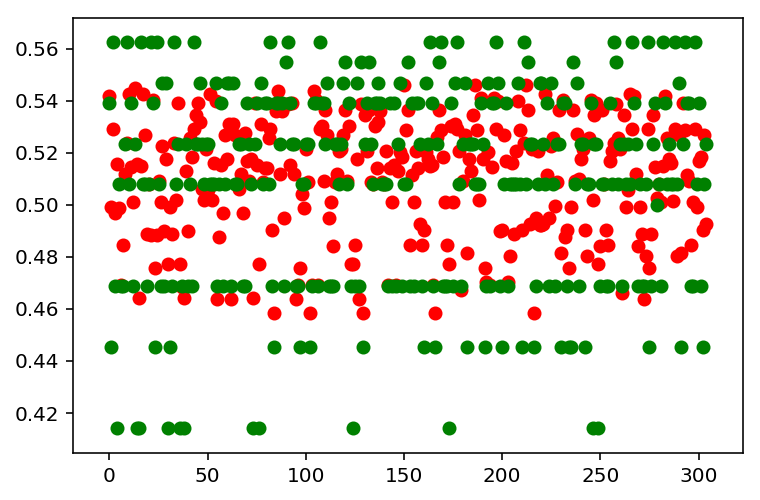

In [801]:
plt.scatter(range(len(results)), results, c='r')
plt.scatter(range(len(y_test)), y_test, c='g')

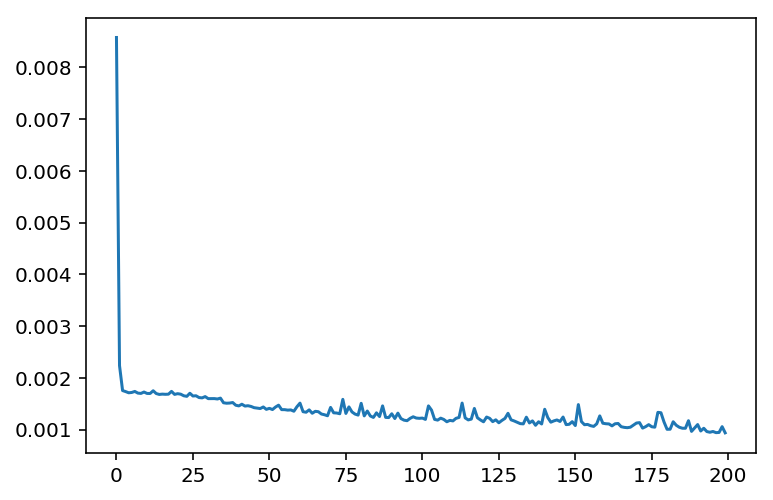

In [802]:
plt.plot(history.history['loss'])